# Chapter 19 - Mixture models

In [ ]:
library(MASS)

## be careful to load dplyr after MASS
library(dplyr)
library(tidyr)
library(purrr)
library(extraDistr)
library(ggplot2)
library(loo)
library(bridgesampling)
library(brms)
library(bayesplot)
library(tictoc)
library(hypr)
library(bcogsci)
library(lme4)
library(rstan)
# library(cmdstanr)
library(rootSolve)

In [3]:
## Save compiled models:
rstan_options(auto_write = FALSE)
## Parallelize the chains using all the cores:
options(mc.cores = parallel::detectCores())
# To solve some conflicts between packages
select <- dplyr::select
extract <- rstan::extract

## Excercises

## 19.1

Change the true value of p_correct to .5 and .1, and generate data for the non-hierarchical model. Can you recover the value of this parameter without changing the model mixture_rtacc2.stan? Perform posterior predictive checks.

### p_correct = .5

##### Generate data

In [6]:
N <- 1000
x <- c(rep(-.5, N/2), rep(.5, N/2)) # difficulty
x2 <- rep(c(-.5, .5), N/2) # instructions
# Verify that the predictors are crossed:
predictors <- tibble(x, x2)
xtabs(~ x + x2, predictors)

      x2
x      -0.5 0.5
  -0.5  250 250
  0.5   250 250

In [9]:
alpha <- 5.8
beta <- 0.05
sigma <- .4
sigma2 <- .5
gamma <- 5.2 
p_correct <- .5
# New true values:
p_btask <- .85
beta_task <- 0.5
# Generate data:
alpha_task <- qlogis(p_btask)
p_task <- plogis(alpha_task + x2 * beta_task)
z <- rbern(N, prob = p_task)
rt <- ifelse(z,
             rlnorm(N, meanlog = alpha + beta * x, sdlog = sigma),
             rlnorm(N, meanlog = gamma, sdlog = sigma2))
acc <- ifelse(z, rbern(N, p_correct),
                 rbern(N, .5))
df_dots_simdata4 <- tibble(trial = 1:N,
                           x = x,
                           rt = rt,
                           acc = acc,
                           x2 = x2) %>%
          mutate(diff = if_else(x == .5, "hard", "easy"),
                 emphasis = ifelse(x2 == .5, "accuracy", "speed"))

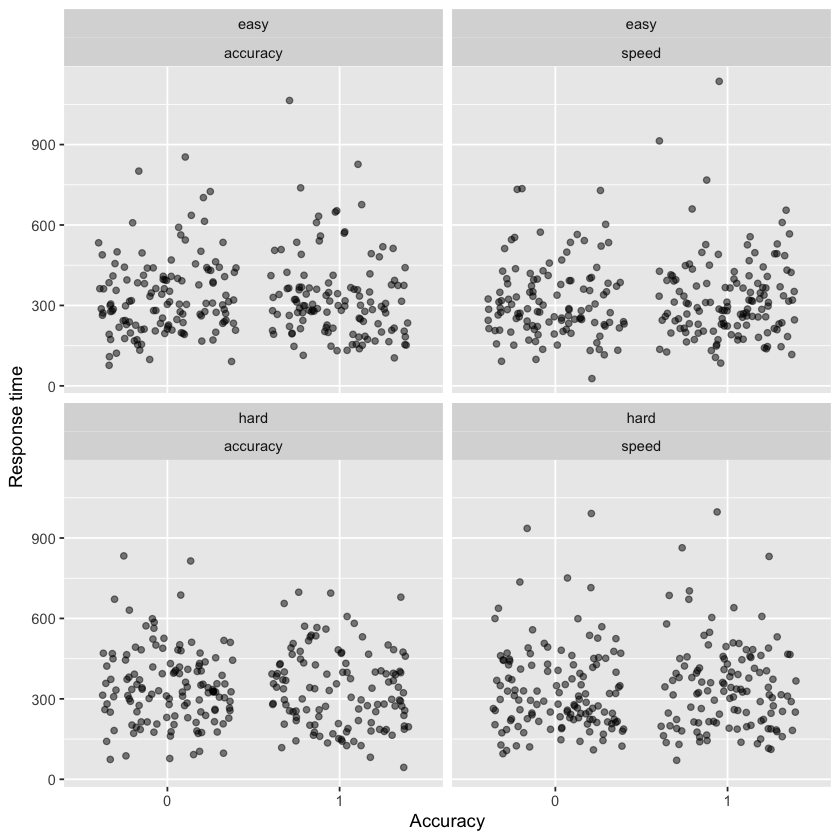

In [10]:
ggplot(df_dots_simdata4, aes(x = factor(acc), y = rt)) +
  geom_point(position = position_jitter(width = .4, height = 0),
             alpha = .5) +
  facet_wrap(diff ~ emphasis) +
  xlab("Accuracy") +
  ylab("Response time") 

##### Fit to the data

In [11]:
ls_dots_simdata <- list(N = N,
                        rt = rt,
                        x = x,
                        x2 = x2,
                        acc = acc,
                        onlyprior = 0) 

In [12]:
fit_mix_rtacc2 <- stan("stan_models_19/mixture_rtacc2.stan", data = ls_dots_simdata)


Warning message:
"There were 4 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


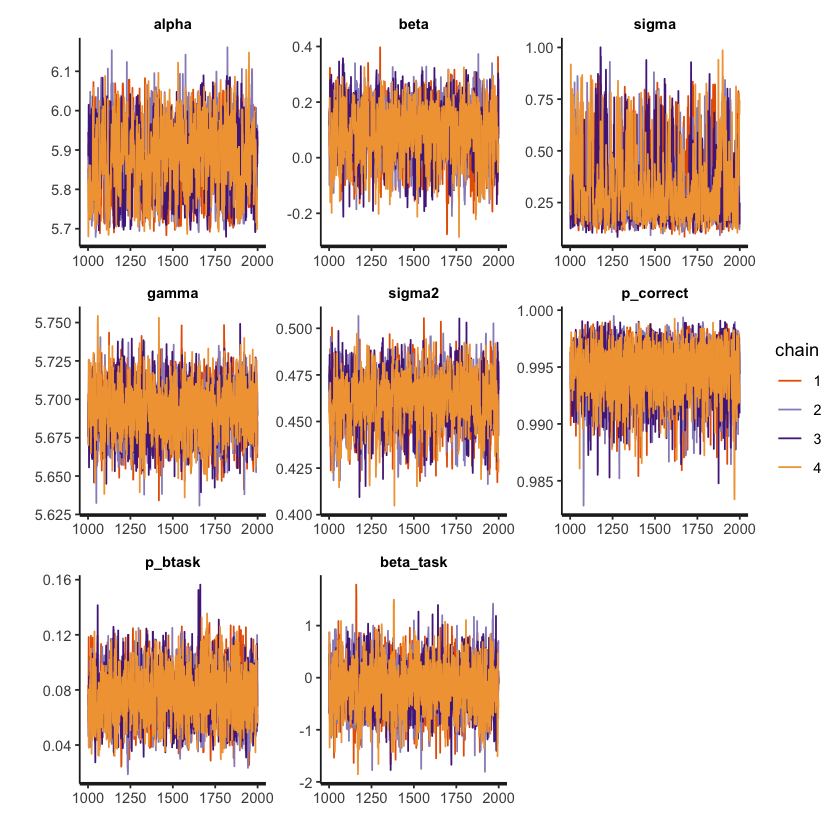

In [15]:
traceplot(fit_mix_rtacc2, pars=c("alpha", "beta", "sigma", "gamma", "sigma2", "p_correct", "p_btask", "beta_task"))

##### Inspect results

In [13]:
print(fit_mix_rtacc2,
      pars = c("alpha", "beta", "sigma", "gamma", "sigma2",
               "p_correct", "p_btask", "beta_task")) 

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd  2.5%   25%   50%  75% 97.5% n_eff Rhat
alpha      5.88    0.00 0.09  5.71  5.82  5.89 5.95  6.05   737 1.01
beta       0.09    0.00 0.10 -0.12  0.03  0.10 0.16  0.27  1236 1.00
sigma      0.32    0.01 0.17  0.13  0.20  0.27 0.39  0.75   643 1.00
gamma      5.69    0.00 0.02  5.66  5.68  5.69 5.70  5.73  2290 1.00
sigma2     0.46    0.00 0.01  0.43  0.45  0.46 0.47  0.49  1369 1.00
p_correct  0.99    0.00 0.00  0.99  0.99  1.00 1.00  1.00  3538 1.00
p_btask    0.07    0.00 0.02  0.04  0.06  0.07 0.09  0.11  2430 1.00
beta_task -0.18    0.01 0.48 -1.13 -0.49 -0.18 0.13  0.72  2315 1.00

Samples were drawn using NUTS(diag_e) at Fri Sep 16 12:04:21 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, R

In [16]:
# extract data from fit
df_fit_mix_rtacc2 <- fit_mix_rtacc2 %>% as.data.frame() %>%
  select(c("alpha", "beta", "sigma", "gamma", "sigma2",
           "p_correct","p_btask", "beta_task"))

# define true values
true_values <- c(alpha, beta, sigma, gamma, sigma2,
                p_correct, p_btask, beta_task)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



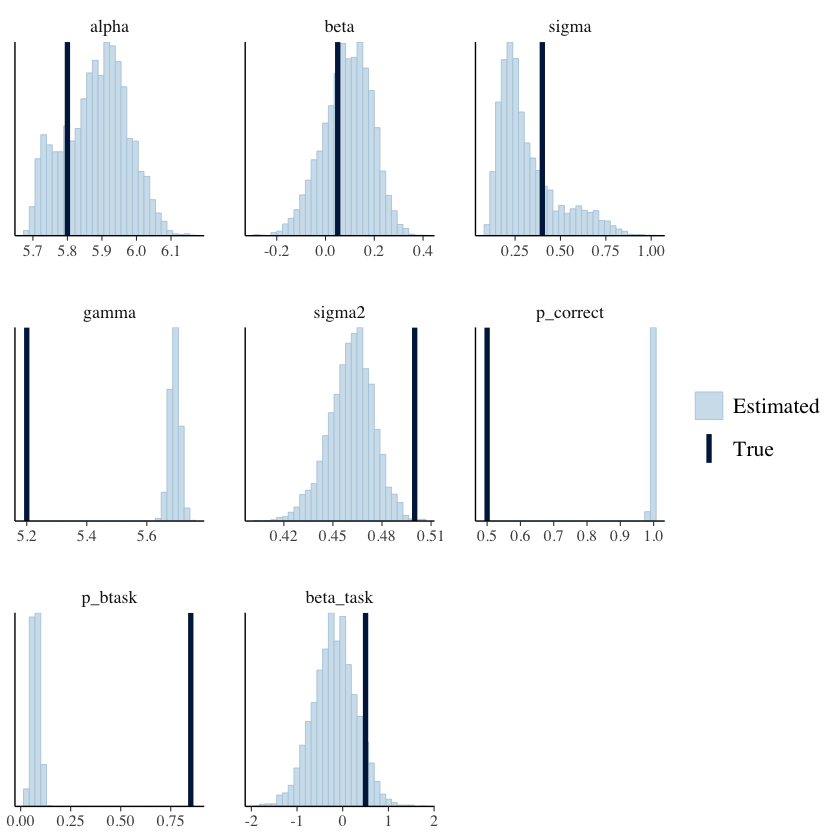

In [17]:
mcmc_recover_hist(df_fit_mix_rtacc2, true_values)

### p-correct = .1

##### Generate data

In [18]:
alpha <- 5.8
beta <- 0.05
sigma <- .4
sigma2 <- .5
gamma <- 5.2 
p_correct <- .1
# New true values:
p_btask <- .85
beta_task <- 0.5
# Generate data:
alpha_task <- qlogis(p_btask)
p_task <- plogis(alpha_task + x2 * beta_task)
z <- rbern(N, prob = p_task)
rt <- ifelse(z,
             rlnorm(N, meanlog = alpha + beta * x, sdlog = sigma),
             rlnorm(N, meanlog = gamma, sdlog = sigma2))
acc <- ifelse(z, rbern(N, p_correct),
                 rbern(N, .5))
df_dots_simdata4 <- tibble(trial = 1:N,
                           x = x,
                           rt = rt,
                           acc = acc,
                           x2 = x2) %>%
          mutate(diff = if_else(x == .5, "hard", "easy"),
                 emphasis = ifelse(x2 == .5, "accuracy", "speed"))

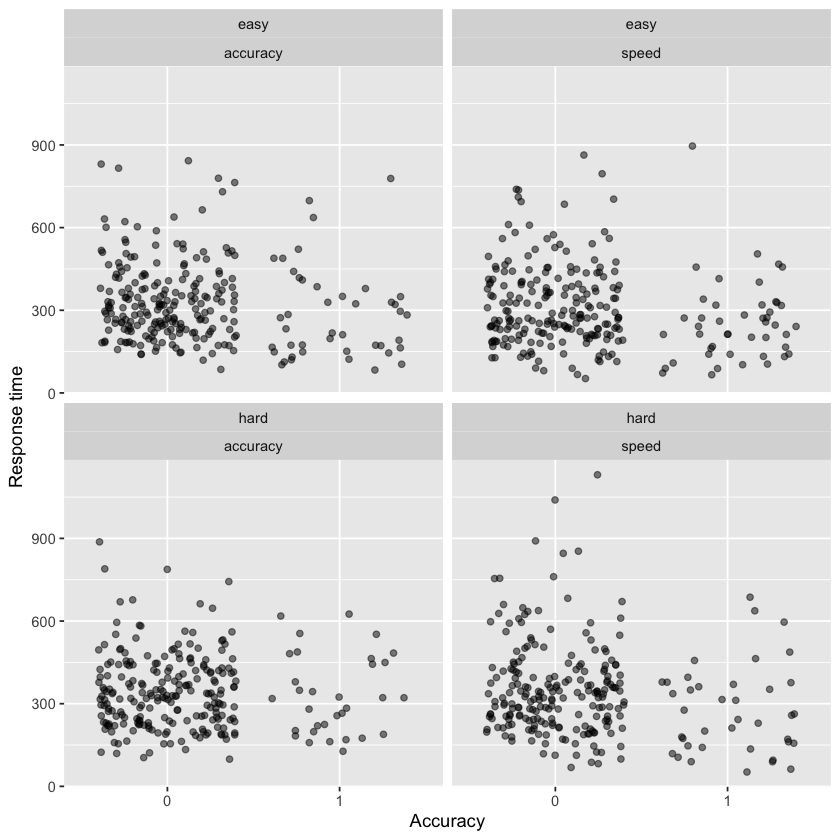

In [19]:
ggplot(df_dots_simdata4, aes(x = factor(acc), y = rt)) +
  geom_point(position = position_jitter(width = .4, height = 0),
             alpha = .5) +
  facet_wrap(diff ~ emphasis) +
  xlab("Accuracy") +
  ylab("Response time") 

##### Fit to the model

In [20]:
ls_dots_simdata <- list(N = N,
                        rt = rt,
                        x = x,
                        x2 = x2,
                        acc = acc,
                        onlyprior = 0) 

In [ ]:
fit_mix_rtacc2_01 <- stan("stan_models_19/mixture_rtacc2.stan", data = ls_dots_simdata)


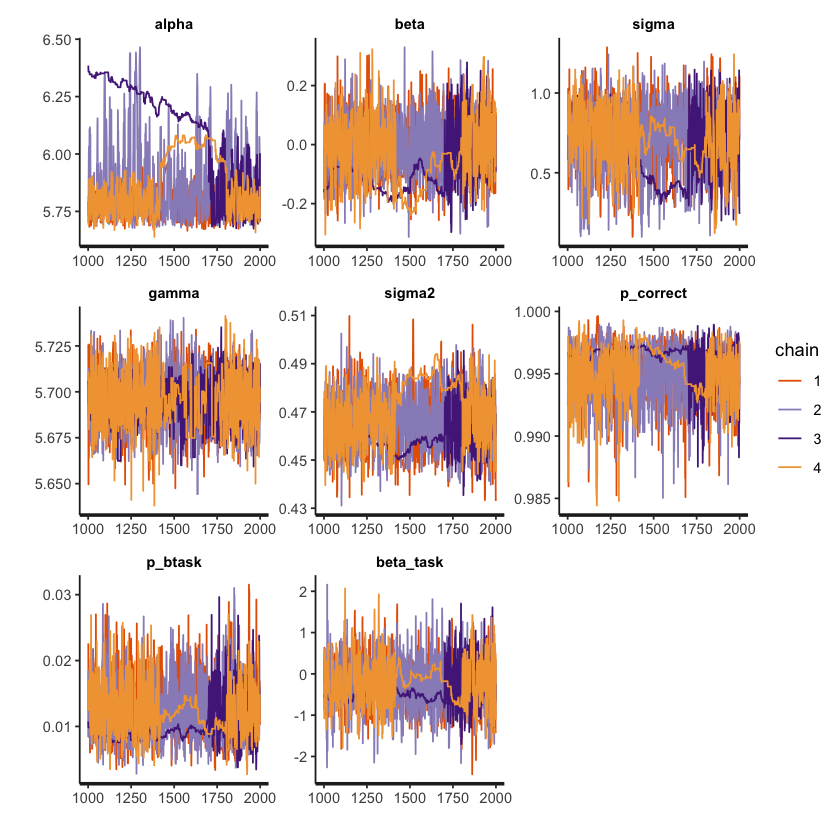

In [22]:
traceplot(fit_mix_rtacc2_01, pars=c("alpha", "beta", "sigma", "gamma", "sigma2", "p_correct", "p_btask", "beta_task"))

##### Inspect the data

In [23]:
print(fit_mix_rtacc2_01,
      pars = c("alpha", "beta", "sigma", "gamma", "sigma2",
               "p_correct", "p_btask", "beta_task")) 

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd  2.5%   25%   50%  75% 97.5% n_eff Rhat
alpha      5.91    0.08 0.19  5.69  5.75  5.84 6.05  6.35     6 1.64
beta      -0.03    0.02 0.11 -0.21 -0.11 -0.04 0.04  0.18    32 1.10
sigma      0.70    0.02 0.20  0.28  0.57  0.72 0.84  1.05    71 1.04
gamma      5.70    0.00 0.01  5.67  5.68  5.70 5.71  5.72  1558 1.00
sigma2     0.47    0.00 0.01  0.45  0.46  0.46 0.47  0.49    29 1.12
p_correct  1.00    0.00 0.00  0.99  0.99  1.00 1.00  1.00    71 1.05
p_btask    0.01    0.00 0.00  0.01  0.01  0.01 0.01  0.02    37 1.07
beta_task -0.27    0.04 0.54 -1.30 -0.61 -0.35 0.06  0.89   231 1.02

Samples were drawn using NUTS(diag_e) at Fri Sep 16 12:19:21 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, R

In [24]:
# extract data from fit
df_fit_mix_rtacc2_01 <- fit_mix_rtacc2_01 %>% as.data.frame() %>%
  select(c("alpha", "beta", "sigma", "gamma", "sigma2",
           "p_correct","p_btask", "beta_task"))

# define true values
true_values <- c(alpha, beta, sigma, gamma, sigma2,
                p_correct, p_btask, beta_task)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



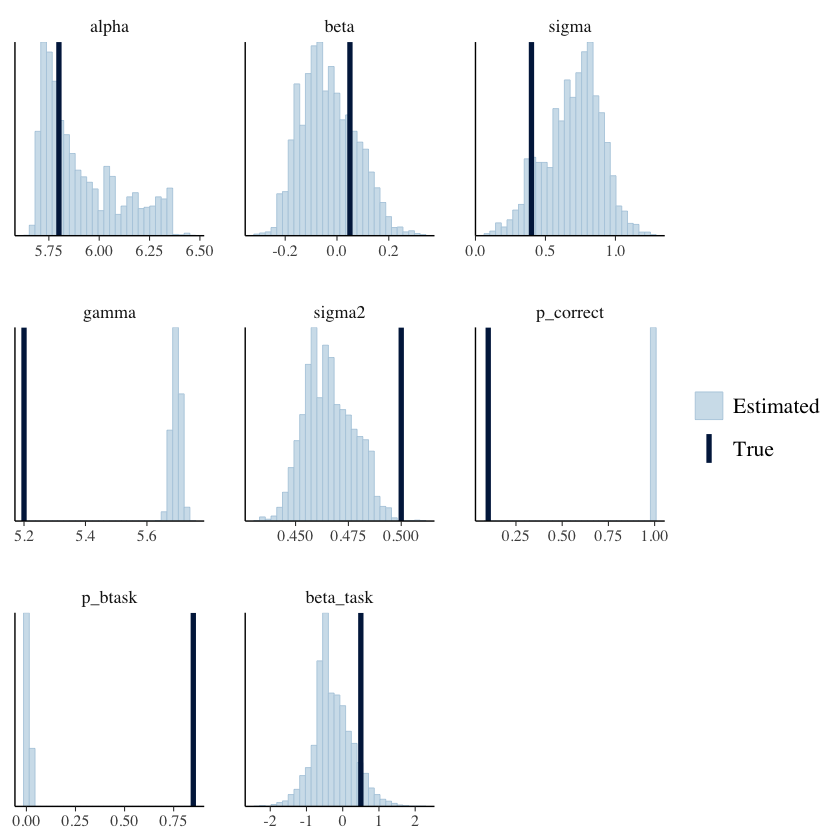

In [25]:
mcmc_recover_hist(df_fit_mix_rtacc2_01, true_values)

## 19.2 - RTs in schizophrenic patients and control.

Response times for schizophrenic patients in a simple visual tracking experiment show more variability than for non-schizophrenic controls; see Figure 19.20. It has been argued that at least some of this extra variability arises from an attentional lapse that delays some responses. We’ll use the data examined in Belin and Rubin (1990) (df_schizophrenia in the bcogsci package) analysis to investigate some potential models:

1. $M_1.$ Both schizophrenic and controls show attentional lapses, but the lapses are more common in schizophrenics. Other than that there is no difference in the latent response times and the lapses of attention.
2. $M_2$. Only schizophrenic patients show attentional lapses. Other than that there is no difference in the latent response times.
3. $M_3$. There no (meaningful number of) lapses of attention in neither group.

In [27]:
# load the data

data("df_schizophrenia")
head(df_schizophrenia)

patient,subj,trial,rt
<int>,<int>,<chr>,<int>
0,1,1,312
0,1,2,272
0,1,3,350
0,1,4,286
0,1,5,268
0,1,6,328


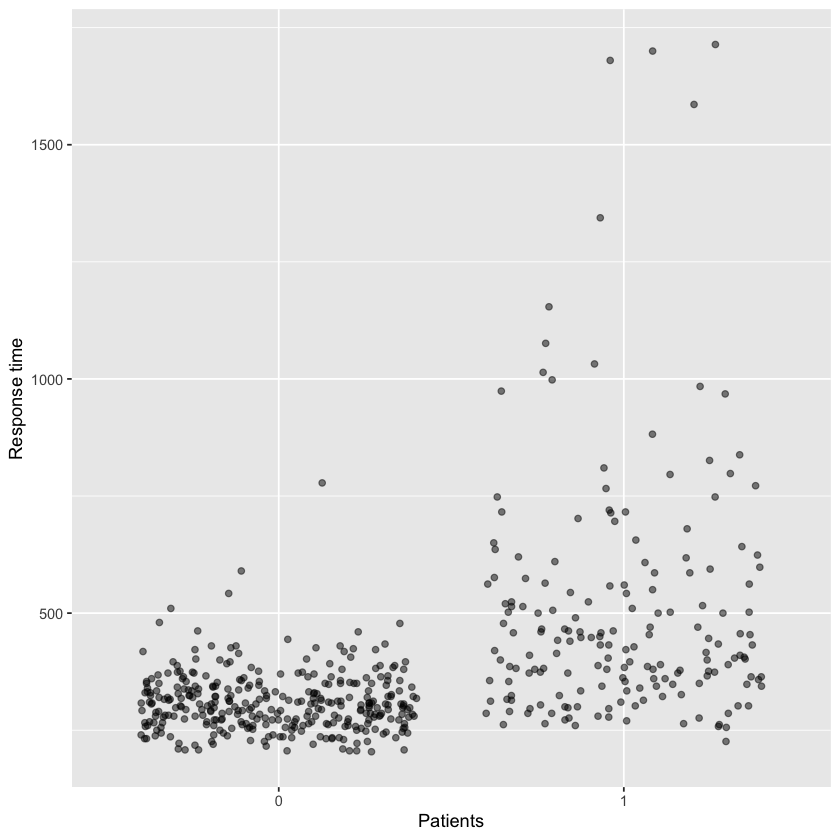

In [29]:
# inspect data

ggplot(df_schizophrenia, aes(x = factor(patient), y = rt)) +
  geom_point(position = position_jitter(width = .4, height = 0),
             alpha = .5) +
#   facet_wrap(diff ~ emphasis) +
  xlab("Patients") +
  ylab("Response time")

### Model 1

\begin{equation}
rt_n \sim 
\begin{cases}
\mathit{LogNormal}(\alpha, \sigma), & \text{ if } z_n =1 \\
\mathit{LogNormal}(\gamma, \sigma_2), & \text{ if } z_n=0
\end{cases}
\end{equation}


And for patients, probability of $z$ is lower than for non-schizofrenia

In [32]:
# simulate data
N <- 1000

# Parameters true values
alpha <- 5.2
sigma <- .4

sigma2 <- .5
gamma <- 6.2

# Median time
c("engaged" = exp(alpha), "lapses" = exp(gamma))

engaged   lapses 
181.2722 492.7490

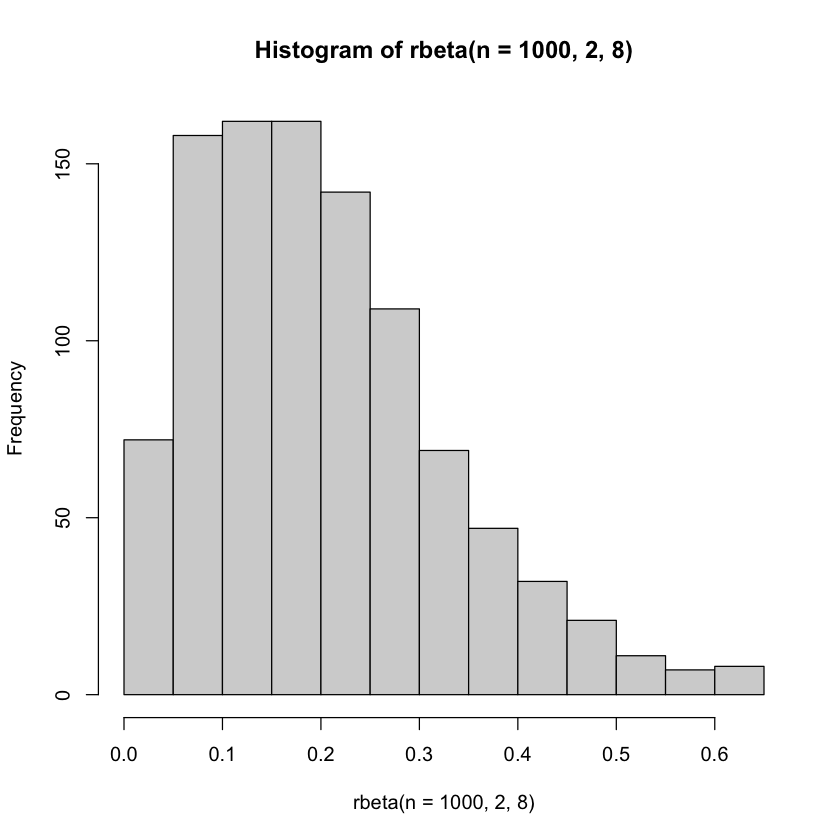

In [78]:
hist(rbeta(n=1000,2,8))

In [38]:
# for patients
p_task <- .6

z <- rbern(n = N, prob = p_task)
rt <- if_else(z == 1,
             rlnorm(N,
                    meanlog = alpha,
                    sdlog = sigma),
             rlnorm(N, 
                    meanlog = gamma,
                    sdlog = sigma2))
df_patients_simdata <- tibble(trial = 1:N, rt = rt)

In [39]:
# for non-patients
p_task <- .95

z <- rbern(n = N, prob = p_task)
rt <- if_else(z == 1,
             rlnorm(N,
                    meanlog = alpha,
                    sdlog = sigma),
             rlnorm(N, 
                    meanlog = gamma,
                    sdlog = sigma2))
df_non_patients_simdata <- tibble(trial = 1:N, rt = rt)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



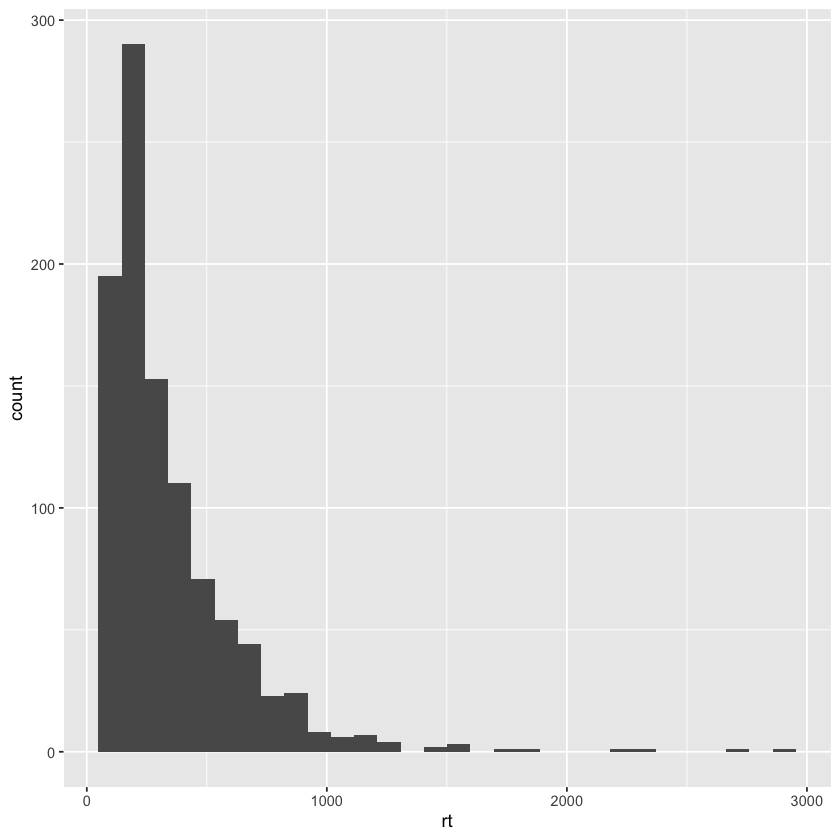

In [40]:
ggplot(df_patients_simdata, aes(rt)) +
  geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



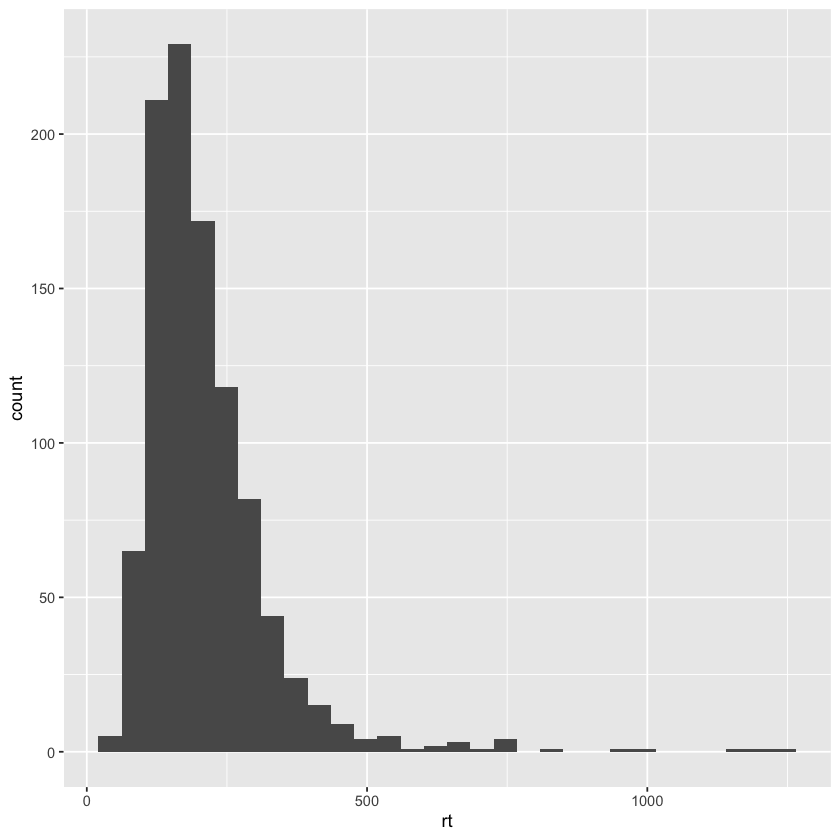

In [37]:
ggplot(df_non_patients_simdata, aes(rt)) +
  geom_histogram()

In [53]:
# test model on simulated data

df_patients_simdata = df_patients_simdata %>%
    mutate(patient = 1)

df_non_patients_simdata = df_non_patients_simdata %>%
    mutate(patient = 0)

df_sim = rbind(df_patients_simdata, df_non_patients_simdata)

In [68]:
# data for Stan model

ls_schizofrenia_simdata <- list(N = nrow(df_sim), rt = df_sim$rt, patient = df_sim$patient) 

In [90]:
fit_mix_schizofrenia_1 <- stan("stan_models_19/mixture_m1.stan", data = ls_schizofrenia_simdata)   

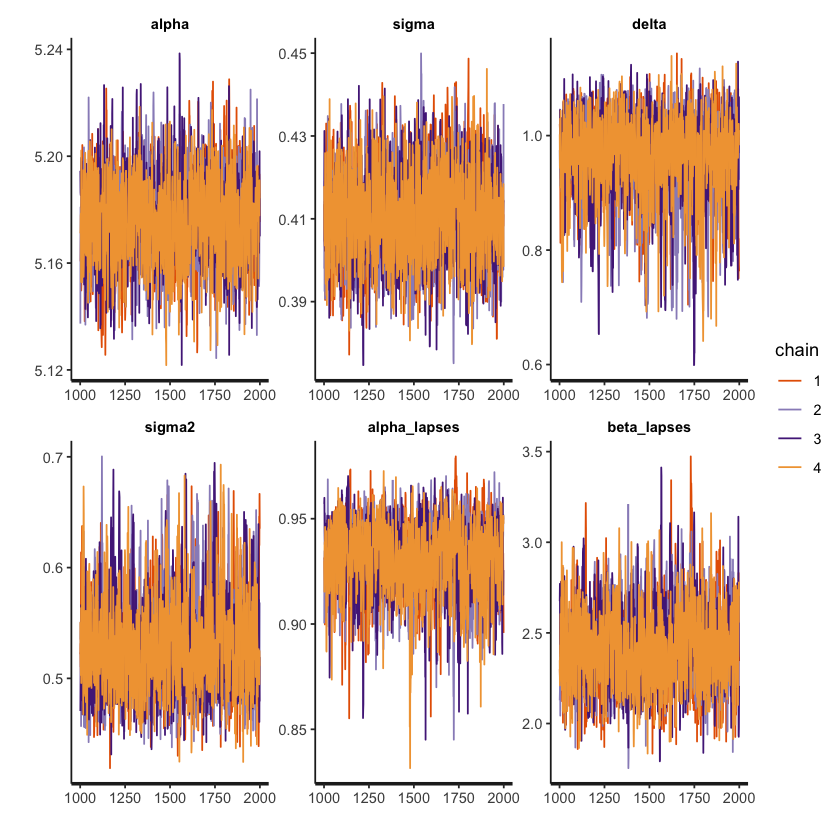

In [97]:
traceplot(fit_mix_schizofrenia_1, pars=c("alpha", "sigma", "delta", "sigma2", "alpha_lapses", "beta_lapses"))

In [98]:
print(fit_mix_schizofrenia_1,
      pars=c("alpha", "sigma", "delta", "sigma2", "alpha_lapses", "beta_lapses")) 

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
alpha        5.18    0.00 0.02 5.14 5.16 5.18 5.19  5.21  1985    1
sigma        0.41    0.00 0.01 0.39 0.40 0.41 0.42  0.43  2062    1
delta        0.96    0.00 0.08 0.77 0.92 0.97 1.01  1.08  1166    1
sigma2       0.53    0.00 0.04 0.46 0.50 0.53 0.56  0.63  1279    1
alpha_lapses 0.93    0.00 0.02 0.89 0.92 0.93 0.94  0.96  1330    1
beta_lapses  2.42    0.01 0.22 2.03 2.28 2.41 2.56  2.87  1634    1

Samples were drawn using NUTS(diag_e) at Fri Sep 16 15:19:22 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [111]:
df_fit_mix_schizofrenia_1 <- fit_mix_schizofrenia_1 %>% as.data.frame() %>%
  select(pars=c("alpha", "sigma", "sigma2", "alpha_lapses"))

true_values <- c(alpha, sigma, sigma2, p_task)

baysesplot::mcmc_recover_hist(df_fit_mix_schizofrenia_1, true_values)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



ERROR: Error in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : nie znaleziono krawedzi wielokata


plot without title

Real data

In [113]:
ls_schizofrenia_data <- list(N = nrow(df_schizophrenia), rt = df_schizophrenia$rt, patient = df_schizophrenia$patient) 

In [123]:
fit_mix_schizofrenia_real_1 <- stan("stan_models_19/mixture_m1.stan", data = ls_schizofrenia_data)   

Warning message:
"The largest R-hat is 1.74, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


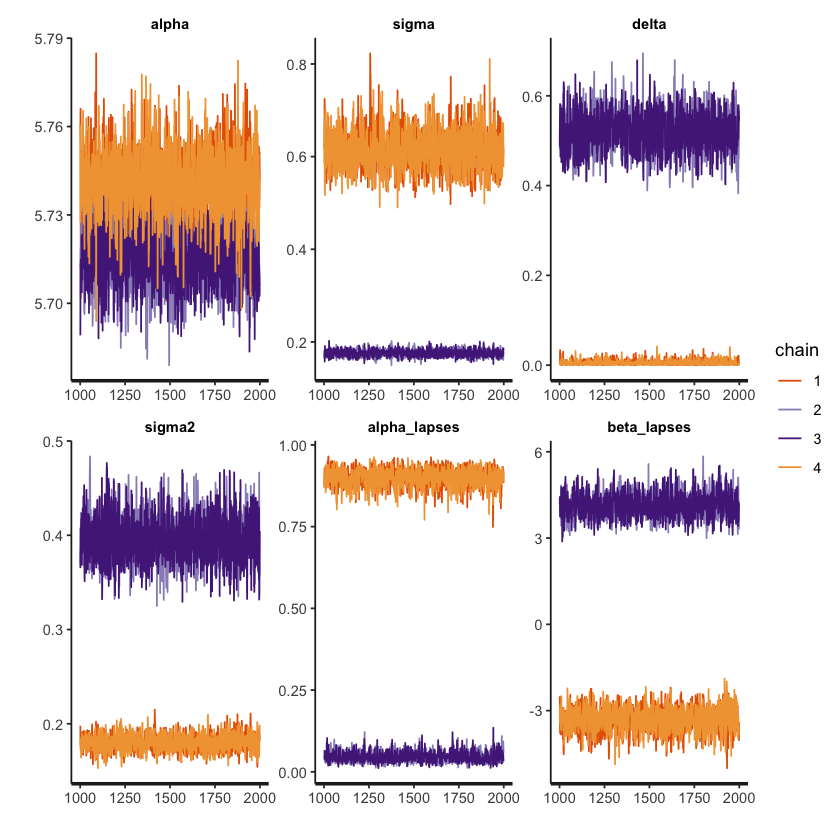

In [124]:
traceplot(fit_mix_schizofrenia_real_1, pars=c("alpha", "sigma", "delta", "sigma2", "alpha_lapses", "beta_lapses"))

In [125]:
print(fit_mix_schizofrenia_real_1,
      pars=c("alpha", "sigma", "delta", "sigma2", "alpha_lapses", "beta_lapses")) 

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean   sd  2.5%   25%  50%  75% 97.5% n_eff  Rhat
alpha        5.73    0.01 0.02  5.70  5.71 5.73 5.74  5.76     3  1.56
sigma        0.40    0.16 0.22  0.16  0.18 0.35 0.61  0.69     2  7.67
delta        0.26    0.18 0.26  0.00  0.00 0.21 0.52  0.59     2  8.57
sigma2       0.29    0.08 0.11  0.17  0.18 0.27 0.40  0.44     2  6.26
alpha_lapses 0.47    0.30 0.43  0.02  0.04 0.44 0.90  0.94     2 20.20
beta_lapses  0.41    2.64 3.76 -4.05 -3.31 0.50 4.13  4.88     2  9.36

Samples were drawn using NUTS(diag_e) at Fri Sep 16 16:19:33 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Hierarchical

In [126]:
head(df_schizophrenia)

patient,subj,trial,rt
<int>,<int>,<chr>,<int>
0,1,1,312
0,1,2,272
0,1,3,350
0,1,4,286
0,1,5,268
0,1,6,328


In [127]:
max(df_schizophrenia$subj)

[1] 17

In [128]:
ls_schizofrenia_data <- list(
    N = nrow(df_schizophrenia), 
    rt = df_schizophrenia$rt, 
    patient = df_schizophrenia$patient,
    N_subj = max(df_schizophrenia$subj),
    subj = df_schizophrenia$subj
) 

In [134]:
fit_mix_schizofrenia_real_h1 <- stan("stan_models_19/mixture_h_m1.stan", data = ls_schizofrenia_data)   

Warning message:
"There were 44 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 2.1, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


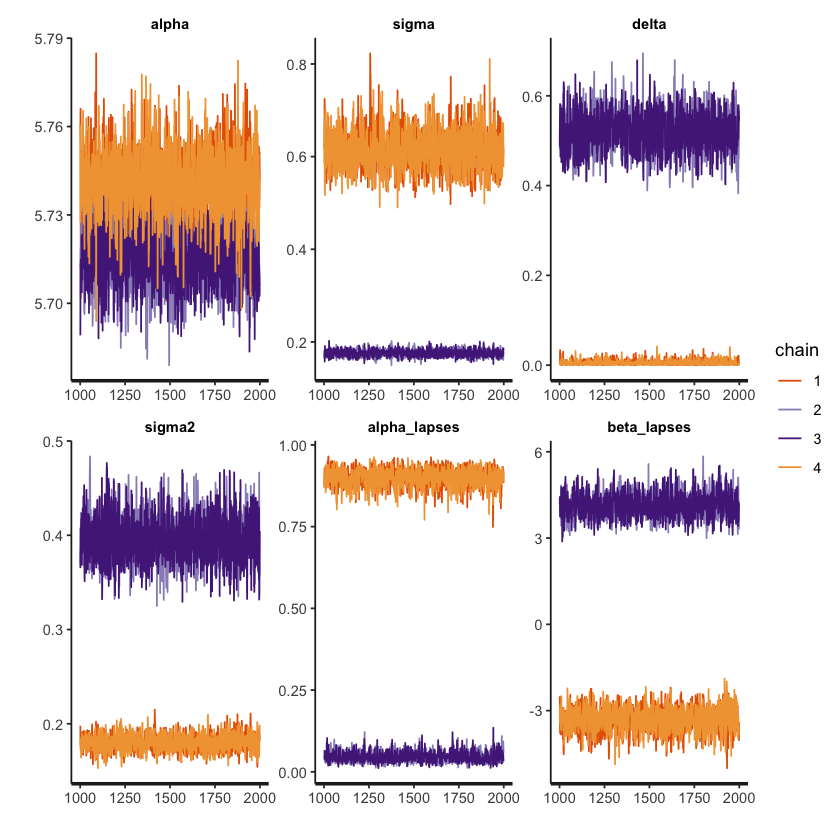

In [136]:
traceplot(fit_mix_schizofrenia_real_1, pars=c("alpha", "sigma", "delta", "sigma2", "alpha_lapses", "beta_lapses"))

In [132]:
fit_mix_schizofrenia_real_h1

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean   sd     2.5%      25%      50%      75%    97.5%
alpha            5.78    0.00 0.06     5.66     5.74     5.78     5.82     5.91
delta            0.04    0.00 0.04     0.00     0.01     0.03     0.06     0.15
sigma            0.30    0.00 0.03     0.25     0.28     0.30     0.32     0.38
sigma2           0.13    0.00 0.01     0.11     0.12     0.13     0.13     0.15
alpha_lapses     0.80    0.00 0.05     0.71     0.77     0.81     0.84     0.89
beta_lapses     -1.28    0.01 0.30    -1.88    -1.48    -1.27    -1.08    -0.69
z[1,1]          -0.01    0.36 0.57    -0.97    -0.49    -0.01     0.49     0.94
z[1,2]           0.04    0.01 0.45    -0.84    -0.22     0.03     0.32     0.98
z[2,1]           0.00    0.28 0.51    -0.96    -0.38    -0.01     0.38     0.95
z[2,2]          -0.12    0.15 0.53    -1.11 

#### Model 2:

No mixture model for control; mixture model for patients - with if(patient) in likelihood.